**Importing Nesseccary Libraries**

In [ ]:
import numpy as np
import pandas as pd
import random
import itertools

import matplotlib.pyplot as plt
import matplotlib
from tabulate import tabulate

from google.colab import drive

from sklearn import preprocessing
from sklearn.model_selection import train_test_split as trainTestSplitter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import plot_confusion_matrix as plotConfustionMatrix
from sklearn.metrics import f1_score as f1Score
from sklearn.metrics import roc_curve as ROC 
from sklearn.metrics import roc_auc_score as AUC

random.seed(30)
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
IrisSetosa = 0
IrisVersicolor = 1
IrisVirginica = 2

Plotting Different Features


In [ ]:
def plotClasses(iris, feature1, feature2):

    plt.scatter(iris[feature1][(iris.Class == 'Iris-setosa')], iris[feature2][(iris.Class == 'Iris-setosa')],
                marker='*', color='mediumpurple', label='Iris Setosa')
    plt.scatter(iris[feature1][(iris.Class == 'Iris-versicolor')], iris[feature2][(iris.Class == 'Iris-versicolor')],
                marker='X', color='slateblue', label='Iris Versicolor')
    plt.scatter(iris[feature1][(iris.Class == 'Iris-virginica')], iris[feature2][(iris.Class == 'Iris-virginica')],
                marker = 'P', color = 'thistle', label = 'Iris Virginica')
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.legend(loc="upper right")
    plt.show()

Part A:

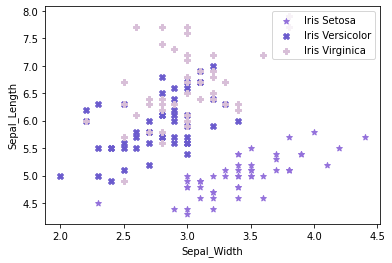

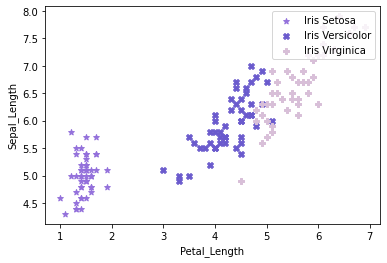

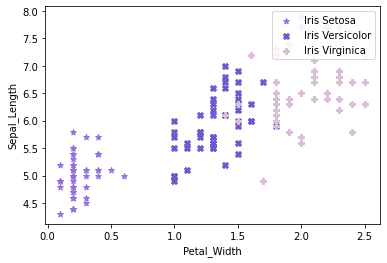

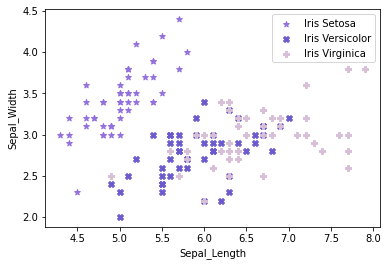

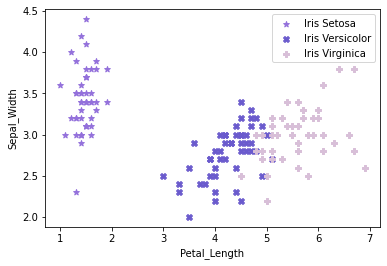

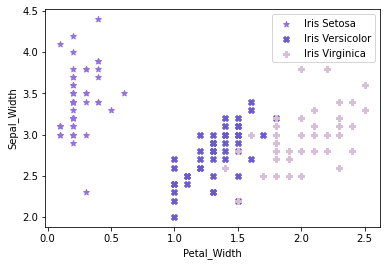

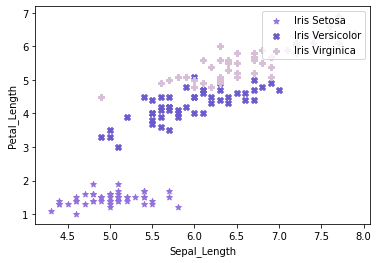

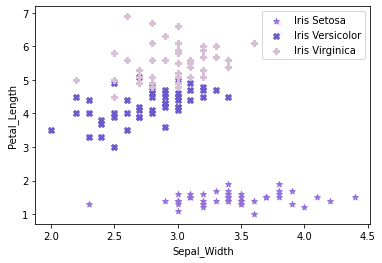

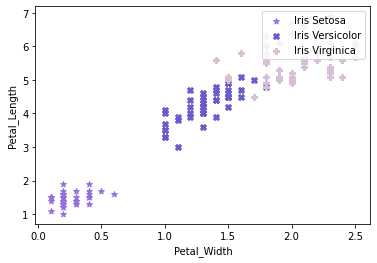

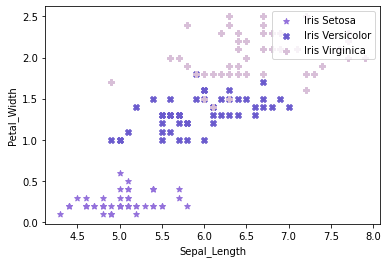

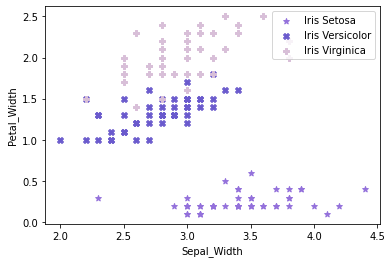

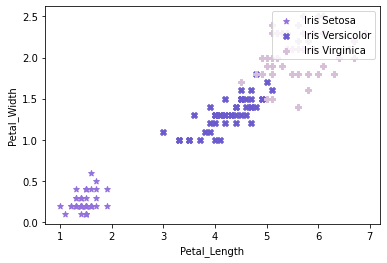

In [ ]:
iris = pd.read_csv(r'/content/gdrive/My Drive/Colab Notebooks/HW/2/Iris.csv')

[[plotClasses(iris, feature1, feature2) for feature1 in iris.columns[0:4] if not feature1==feature2] for feature2 in iris.columns[0:4]]

#Shuffling the Iris Dataset:
iris = iris.sample(frac = 1)

Part B:

Separating Train and Test Data

In [ ]:
def splitData(X, y):
  indexes = random.sample(range(0, 149), 20)
  indexes.sort()

  testData = X[indexes]
  testLabel = y[indexes]

  XList = X.tolist()
  for i in range(20):
    XList.pop(indexes[i]-i)
  trainData = np.array(XList)

  y = np.delete(y, indexes)
  trainLabel = y

  return trainData, trainLabel, testData, testLabel

Nearest Neighbor Classifier

In [ ]:
def NNC(trainData, trainLabel, testData):
  neighIndexes = []
  for i in range(len(testData)):
    distances = np.linalg.norm(testData[i]-trainData, axis=1)
    neighIndexes.append((np.argsort(distances))[0])

  if not neighIndexes:
    print('The classifier could not predict labels. Try Again!' + '.' * 5)
  else:
    print('The classifier successefully predicted labels' + '.' * 5)
    return trainLabel[neighIndexes]


Calculating Accuracy

In [ ]:
def calcAcc(predLabels, testLabels):
  return (predLabels==testLabels).mean()*100

Normalizing Data


In [ ]:
def normData(data, numOfFeatures):
  newData = np.zeros((len(data), numOfFeatures))
  for clm in range(numOfFeatures):
    meanValue = np.mean(data[:,clm])
    stdValue = np.sqrt(np.var(data[:,clm]))
    newData[:,clm] = (data[:,clm]-meanValue)/stdValue
  return newData

Main

In [ ]:
#Extracting Features:
X = iris[iris.columns[0:4]]
X = X.values

#Extracting Labels:
y = iris[iris.columns[4]]
y = y.values

#Set the Labels to 0, 1, and 2:
newY = np.zeros((len(y)), dtype=int)
for i in range(0,len(y)-1):
  if y[i] == 'Iris-setosa':
    newY[i] = IrisSetosa
  elif y[i] == 'Iris-versicolor':
    newY[i] = IrisVersicolor
  else:
    newY[i] = IrisVirginica
y = np.copy(newY)

#Splitting Data into Test and Train Sets. 
trainData, trainLabels, testData, testLabels = splitData(X, y)

#Predicting Labels by "Nearest Neighbor Classifier":
predLabels = NNC(trainData, trainLabels, testData)

#Calculating Accuracy:
print('Accuracy of non-normalized data is: %% %1.2f' %(calcAcc(predLabels, testLabels)))

#Normalizing Test and Train Data:
normTrainData = normData(trainData, 4)
normTestData = normData(testData, 4)

#Predicting Labels of Normalized Data by "Nearest Neighbor Classifier":
predLabelsNorm = NNC(normTrainData, trainLabels, normTestData)

#Calculating Accuracy:
print('Accuracy of normalized data is: %% %1.2f' %(calcAcc(predLabelsNorm, testLabels)))

The classifier successefully predicted labels.....
Accuracy of non-normalized data is: % 95.00
The classifier successefully predicted labels.....
Accuracy of normalized data is: % 90.00


Part C:

Confusion Matrix:

In [ ]:
def calcConfMat(testLabels, predLabels):
  
  classLabels = np.unique(testLabels)  
  return np.array([[np.sum((testLabels == classLabels[i]) & (predLabels == classLabels[j])) for j in range(len(classLabels))] for i in  range(len(classLabels))]) 

Plot Matrix

In [ ]:
def plotConfMatrix(matrix, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Purples):
    plt.figure(figsize = (5,5))
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=10, fontweight='bold')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks([-0.5, -0.25, 0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5], 
              ['', '', classes[0], '', '', '', classes[1], '', '', '', classes[2], '', ''])
    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, matrix[i, j], ha='center', va='center', color='lavender' if matrix[i,j]>thresh else 'mediumpurple')
    plt.tight_layout()
    plt.ylabel('True Labels', fontsize=10, fontweight='bold')
    plt.xlabel('Predicted Lables', fontsize=10, fontweight='bold')
    plt.show()

Calculating Recall Using Confusion Matrix

In [ ]:
def calcRecallConfMat(confMat):
    
    FN = confMat.sum(axis=1) - np.diag(confMat)
    TP = np.diag(confMat)
    
    return TP/(TP+FN)

Calculating Precision Using Confusion Matrix

In [ ]:
def calcPrecisionConfMat(confMat):  
    FP = confMat.sum(axis=0) - np.diag(confMat) 
    TP = np.diag(confMat)
    
    return TP/(TP+FP)

Print Tables Beautifully :)

In [ ]:
def plotTable(clms, clmDataHeadears, alignSize):
    data = []
    
    for i in range(len(clms[list(clms.keys())[0]])):
        dataElement = []
        for key in clms.keys():
            dataElement.append(clms[key][i])
        data.append(dataElement)
        
    print(tabulate(data, headers=clmDataHeadears, tablefmt="fancy_grid", 
                   colalign=["center"]*alignSize))

Calulate F1 Scores:

In [ ]:
def calcF1Score(matrix):
  f1Scores = 2 * calcPrecisionConfMat(matrix) * calcRecallConfMat(matrix)/(calcPrecisionConfMat(matrix)+calcRecallConfMat(matrix))
  plotTable({1:["F1 Score"], 
                2:['{:1.2f}'.format(f1Scores[0])],
                3:['{:1.2f}'.format(f1Scores[1])],
                4:['{:1.2f}'.format(f1Scores[2])]},
                ['', 'Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], 4) 

Main

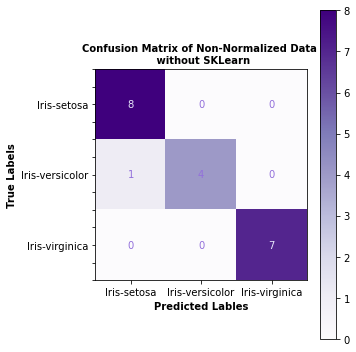

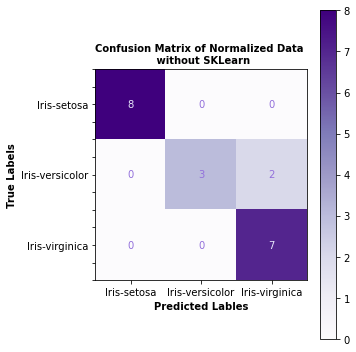

╒══════════╤═══════════════╤═══════════════════╤══════════════════╕
│          │  Iris-setosa  │  Iris-versicolor  │  Iris-virginica  │
╞══════════╪═══════════════╪═══════════════════╪══════════════════╡
│ F1 Score │     0.94      │       0.89        │        1         │
╘══════════╧═══════════════╧═══════════════════╧══════════════════╛
╒══════════╤═══════════════╤═══════════════════╤══════════════════╕
│          │  Iris-setosa  │  Iris-versicolor  │  Iris-virginica  │
╞══════════╪═══════════════╪═══════════════════╪══════════════════╡
│ F1 Score │       1       │       0.75        │       0.88       │
╘══════════╧═══════════════╧═══════════════════╧══════════════════╛


In [ ]:
#Employing Non-normalized Data for Calculating Confusion Matrix:
myConfMat = calcConfMat(testLabels, predLabels)
plotConfMatrix(myConfMat, ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], title='Confusion Matrix of Non-Normalized Data \n without SKLearn')

#Employing Normalized Data for Calculating Confusion Matrix:
myConfMatNormData = calcConfMat(testLabels, predLabelsNorm)
plotConfMatrix(myConfMatNormData, ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], title='Confusion Matrix of Normalized Data \n without SKLearn')

#F1 Score of Classes for Non-normalized Data:
calcF1Score(myConfMat)

#F1 Score of Classes for Normalized Data:
calcF1Score(myConfMatNormData)

Part D:

Plotting Confusion Matrix with SKLearn

In [ ]:
def plotConfMatSK(myClsf, testDataSK, testLabelsSK, dispLabels, matrixTitle):
  disp = plotConfustionMatrix(myClsf, testDataSK, testLabelsSK, display_labels=dispLabels, cmap=plt.cm.Purples)
  disp.ax_.set_title(matrixTitle)
  plt.show()

Calculate F1 Score with SKLearn

In [ ]:
def calcf1ScoreSK(testLabels, predLabels):
  f1Scores = f1Score(testLabels, predLabels, average=None)
  plotTable({1:["F1 Score"], 
                2:['{:1.2f}'.format(f1Scores[0])],
                3:['{:1.2f}'.format(f1Scores[1])],
                4:['{:1.2f}'.format(f1Scores[2])]},
                ['', 'Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], 4) 

Plotting ROC Curve and Calculating AUC

In [ ]:
def binerizeClass(myClsf, trainData, trainLabels, testData, testLabels):
  trainLabels = (preprocessing.label_binarize(trainLabels, classes=[0, 1, 2]))
  testLabels = (preprocessing.label_binarize(testLabels, classes=[0, 1, 2]))
  newClsf = OneVsRestClassifier(myClsf)
  newClsf.fit(trainData, trainLabels)
  predLabels = (newClsf.predict(testData))

  return testLabels, predLabels

def ROCandAUC(myClsf, trainData, trainLabels, testData, testLabels, plotTitle):

  #Binarize the Classifier and Data:
  testLabels, predLabels = binerizeClass(myClsf, trainData, trainLabels, testData, testLabels)
  numOfClasses = 3

  # Compute ROC curve and AUC for Each Class:
  falseAlarm = dict()
  hit = dict()
  AUCs = dict()

  for i in range(numOfClasses):
      falseAlarm[i], hit[i], _ = ROC(testLabels[:,i], predLabels[:,i])
      AUCs[i] = AUC(testLabels[:,i], predLabels[:,i])

  # Plot of a ROC curve for a specific class
  for i in range(numOfClasses):
      plt.figure()
      plt.plot(falseAlarm[i], hit[i], color='mediumpurple')
      plt.plot([0, 1], [0, 1], '--', color='thistle')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Alarm')
      plt.ylabel('Hit')
      plt.title(plotTitle)
      plt.show()

  plotTable({1:["AUC"], 
                2:['{:1.4f}'.format(AUCs[0])],
                3:['{:1.4f}'.format(AUCs[1])],
                4:['{:1.4f}'.format(AUCs[2])]},
                ['', 'Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], 4) 

Main

Accuracy of non-normalized data using SKLearn library is: % 93.33
Accuracy of normalized data using SKLearn library is: % 93.33


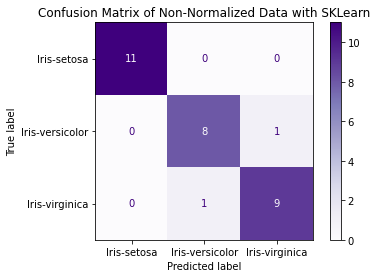

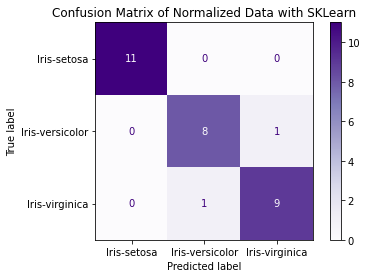

╒══════════╤═══════════════╤═══════════════════╤══════════════════╕
│          │  Iris-setosa  │  Iris-versicolor  │  Iris-virginica  │
╞══════════╪═══════════════╪═══════════════════╪══════════════════╡
│ F1 Score │       1       │       0.89        │       0.9        │
╘══════════╧═══════════════╧═══════════════════╧══════════════════╛
╒══════════╤═══════════════╤═══════════════════╤══════════════════╕
│          │  Iris-setosa  │  Iris-versicolor  │  Iris-virginica  │
╞══════════╪═══════════════╪═══════════════════╪══════════════════╡
│ F1 Score │       1       │       0.89        │       0.9        │
╘══════════╧═══════════════╧═══════════════════╧══════════════════╛


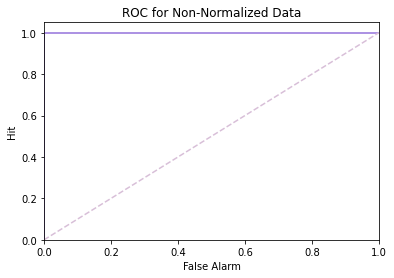

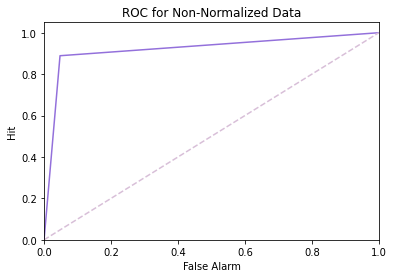

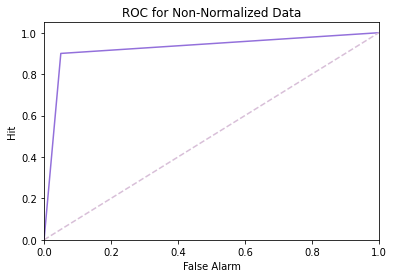

╒═════╤═══════════════╤═══════════════════╤══════════════════╕
│     │  Iris-setosa  │  Iris-versicolor  │  Iris-virginica  │
╞═════╪═══════════════╪═══════════════════╪══════════════════╡
│ AUC │       1       │      0.9206       │      0.925       │
╘═════╧═══════════════╧═══════════════════╧══════════════════╛


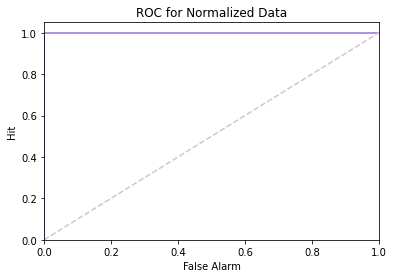

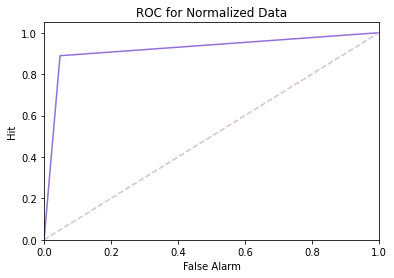

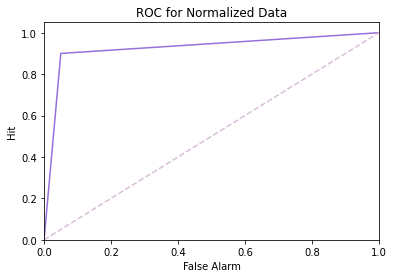

╒═════╤═══════════════╤═══════════════════╤══════════════════╕
│     │  Iris-setosa  │  Iris-versicolor  │  Iris-virginica  │
╞═════╪═══════════════╪═══════════════════╪══════════════════╡
│ AUC │       1       │      0.9206       │      0.925       │
╘═════╧═══════════════╧═══════════════════╧══════════════════╛


In [ ]:
#Splitting Data into Test and Train Sets. 
trainDataSK, testDataSK, trainLabelsSK, testLabelsSK = trainTestSplitter(X, y, test_size =0.2, random_state=30)

#Employing KNN Classifier for k=1:
myClsf1 = KNeighborsClassifier(1) 
myClsf1.fit(trainDataSK, trainLabelsSK)
predLabelsSK = myClsf1.predict(testDataSK)
print('Accuracy of non-normalized data using SKLearn library is: %% %1.2f' %(calcAcc(predLabelsSK, testLabelsSK)))

#Scaling Data:
scaler = preprocessing.StandardScaler().fit(trainDataSK)
normTrainDataSK = scaler.transform(trainDataSK)
normTestDataSK = scaler.transform(testDataSK)

#Employing KNN Classifier for k=1 for Normalized Data:
myClsf2 = KNeighborsClassifier(1) 
myClsf2.fit(normTrainDataSK, trainLabelsSK)
predLabelsSKNorm = myClsf2.predict(normTestDataSK)
print('Accuracy of normalized data using SKLearn library is: %% %1.2f' %(calcAcc(predLabelsSKNorm, testLabelsSK)))

#Employing Non-normalized Data for Calculating Confusion Matrix:
plotConfMatSK(myClsf1, testDataSK, testLabelsSK, ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], 'Confusion Matrix of Non-Normalized Data with SKLearn')

#Employing Normalized Data for Calculating Confusion Matrix:
plotConfMatSK(myClsf2, normTestDataSK, testLabelsSK, ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], 'Confusion Matrix of Normalized Data with SKLearn')

#F1 Score of Classes for Non-normalized Data:
calcf1ScoreSK(testLabelsSK, predLabelsSK)

#F1 Score of Classes for Normalized Data:
calcf1ScoreSK(testLabelsSK, predLabelsSKNorm)

#ROC and AUC for Non-Normalized Data:
ROCandAUC(myClsf1, trainDataSK, trainLabelsSK, testDataSK, testLabelsSK, 'ROC for Non-Normalized Data')

#ROC and AUC for Normalized Data:
ROCandAUC(myClsf2, normTrainDataSK, trainLabelsSK, normTestDataSK, testLabelsSK, 'ROC for Normalized Data')

